In [1]:
%matplotlib inline
from collections import Counter
import douwelib as dl
import os, glob, statistics, numpy as np, matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
from collections import defaultdict
import matplotlib.patches as mpatches
import itertools
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, GlyphRenderer, Range1d
from bokeh.layouts import gridplot
import math
from bokeh.io import export_png


In [2]:
sequence_file = 'C:/Users/Douwe/Documents/Python/Sequence_files/COG_LAB008_20170217_FNFAF05255_MN17942_sequencing_run_RCA_Pool_2_1D_16122_ch90_read1116_strand.done_fastq'

In [3]:
size = 6
overlap = 2
letters = 'ACTG'

In [ ]:
#Automatic plot 
X = np.array(dl.get_list_fastq(sequence_file, size, overlap, letters)[0])
Y_h = dl.get_list_fastq(sequence_file, size, overlap, letters)[1]
Y_m = dl.get_list_fastq(sequence_file, size, overlap, letters)[2]
Y_l = np.array(dl.get_list_fastq(sequence_file, size, overlap, letters)[3])
dl.plot_bases_high_medium_low(X, Y_h, Y_m, Y_l, 1000, 10)

In [ ]:
#What is inside automatic function
data = dl.parse_fasta_file_error(sequence_file)          #reads sequence_file -> makes dictonairy with key = id and value = bases and scores
#print(data)
                                                         
id_ = list(data.keys())[0]                               #makes name id_ from key
error_rate = dl.convert_qualityscore (data[id_]['score']) #converts quality score from symboles to values out of dict

nucleotide_string = (data[id_]['sequence'])
nucleotides_list = [c for c in (data[id_]['sequence'])]  #individualize nucleotides into list out of dict
X = np.array(nucleotides_list)                           #array for nucleotides and error rate
Y = np.array(error_rate)                                 

In [ ]:
Y

In [ ]:
scoremean_dict = dl.dict_scoremean_bases(nucleotide_string, error_rate, size, overlap)

#Now for creating plot with High, Medium and Low
plot_data_h = dl.dict_of_allbases_vs_High_Medium_Low(4, 'High', scoremean_dict, letters)
plot_data_m = dl.dict_of_allbases_vs_High_Medium_Low(4, 'Medium', scoremean_dict, letters)
plot_data_l = dl.dict_of_allbases_vs_High_Medium_Low(4, 'Low', scoremean_dict, letters)

X = np.array(list(plot_data_h.keys()))
Y_h = np.array(list(plot_data_h.values()))
Y_m = np.array(list(plot_data_m.values()))
Y_l = np.array(list(plot_data_l.values()))

plot_data_h.values()

In [ ]:
#For all the files

In [4]:
os.chdir('C:/Users/Douwe/Documents/Python/Sequence_files')
all_y_h = [] 
all_y_m = []
all_y_l = []
size = 5
overlap = 2
letters = 'ACTG'

for file in glob.iglob('*.done_fastq'):
    X = dl.get_list_fastq(file, size, overlap, letters)[0]
    y_h = (dl.get_list_fastq(file, size, overlap, letters)[1])
    y_m = (dl.get_list_fastq(file, size, overlap, letters)[2])
    y_l = (dl.get_list_fastq(file, size, overlap, letters)[3])
    all_y_h.append(y_h)
    all_y_m.append(y_m)
    all_y_l.append(y_l)
    
nc_all_y_h = [[i[n] for i in all_y_h] for n in range(len(all_y_h[0]))]
c_all_y_h = list(sum(x) for x in nc_all_y_h)
nc_all_y_m = [[i[n] for i in all_y_m] for n in range(len(all_y_m[0]))]
c_all_y_m = list(sum(x) for x in nc_all_y_m)
nc_all_y_l = [[i[n] for i in all_y_l] for n in range(len(all_y_l[0]))]
c_all_y_l = list(sum(x) for x in nc_all_y_l)

#dl.plot_bases_high_medium_low(X, c_all_y_h, c_all_y_m, c_all_y_l, 1000, 500)

#get dict with many high error rates and thus low quality
all_combinations = []
for i in itertools.product('ACTG', repeat = size):
    size_ = '{}'*size
    all_combinations.append(size_.format(*i))
    
all_high_scores = dict(zip(all_combinations, c_all_y_h))
d = dict((k, v) for k, v in all_high_scores.items() if v >= 60)


In [5]:
y_nan1 = dl.zero_to_nan(c_all_y_h)
y_nan2 = dl.zero_to_nan(c_all_y_m)
y_nan3 = dl.zero_to_nan(c_all_y_l)

In [ ]:
path = 'C:/Users/Douwe/Documents/Python/Sequence_files'
dl.get_list_hml_scores_fastq(path, size, overlap, letters)[1]

In [6]:
#Plot in Bokeh
bases = 'ACTG'

#percentage
sum_scores = [x + y + z for x, y, z in zip(y_nan1, y_nan2, y_nan3)]
per_h_of_all = [x / y * 100 for x, y in zip(y_nan1, sum_scores)]
per_m_of_all = [x / y * 100 for x, y in zip(y_nan2, sum_scores)]
per_l_of_all = [x / y * 100 for x, y in zip(y_nan3, sum_scores)]

hover = HoverTool(tooltips=[("Bases", "@x"), ("High Scores", "@y""%")], mode='vline')

#plotting
p = figure(x_range=bases, y_axis_label='How many found bases in category%', tools=[hover, 'xwheel_zoom', 'xpan'])
p.title.text = "High, Medium, Low quality score per sequence"
p.xaxis.ticker = []
p.y_range = Range1d(0, 100)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#data
p.circle(x=bases, y=per_h_of_all, size=5, alpha=1, muted_alpha=0.4, color='red', muted_color='red', legend='High scores')
p.circle(x=bases, y=per_m_of_all, size=5, alpha=1, muted_alpha=0.4, color='blue', muted_color='blue', legend='Medium scores')
p.circle(x=bases, y=per_l_of_all, size=5, alpha=1, muted_alpha=0.4, color='purple', muted_color='purple', legend='Low scores')

p.legend.location = "top_left"
p.legend.click_policy="mute"

# output to static HTML file
#output_file("scatterplot.html", title="High, Medium, Low quality score per sequence")

#show(p)

In [ ]:
dl.plot_bases_hml_in_bokeh('D', X, y_nan1, y_nan2, y_nan3)

In [8]:
per_h_of_all

[16.666666666666664,
 18.571428571428573,
 29.03225806451613,
 23.52941176470588,
 14.328358208955224,
 10.674157303370785,
 21.568627450980394,
 14.473684210526317,
 13.46938775510204,
 10.434782608695652,
 14.14141414141414,
 14.84375,
 35.294117647058826,
 36.84210526315789,
 6.521739130434782,
 42.857142857142854,
 9.67741935483871,
 23.118279569892472,
 42.62295081967213,
 14.213197969543149,
 9.620253164556962,
 37.254901960784316,
 31.46067415730337,
 32.87671232876712,
 33.33333333333333,
 31.914893617021278,
 57.71812080536913,
 34.01015228426396,
 41.66666666666667,
 31.20567375886525,
 14.285714285714285,
 36.666666666666664,
 54.054054054054056,
 17.079889807162534,
 52.52525252525253,
 58.536585365853654,
 6.882591093117409,
 6.666666666666667,
 14.285714285714285,
 17.5,
 26.190476190476193,
 30.0,
 11.490683229813664,
 44.776119402985074,
 62.264150943396224,
 22.794117647058822,
 38.88888888888889,
 22.018348623853214,
 32.53012048192771,
 12.631578947368421,
 9.6551724

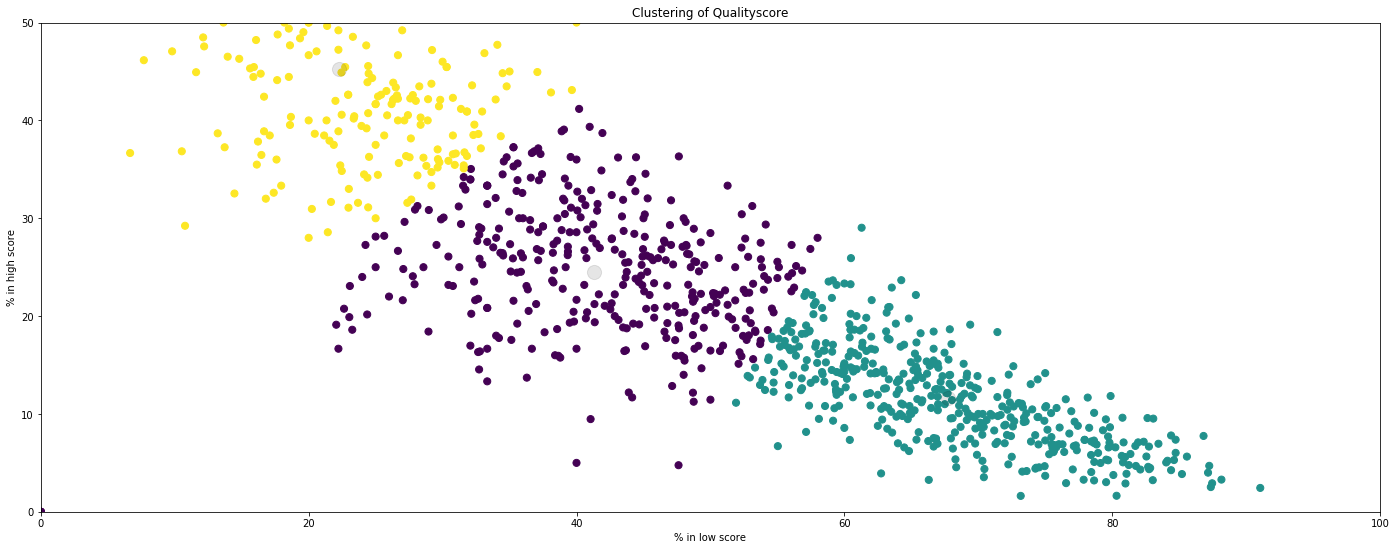

In [27]:
#plotting with clustering
from sklearn.cluster import KMeans

x_plot = np.column_stack(([0 if math.isnan(x) else x for x in per_l_of_all], [0 if math.isnan(x) else x for x in per_h_of_all]))
kmeans= KMeans(n_clusters=3)
kmeans.fit(x_plot)
y_kmeans = kmeans.predict(x_plot)

plt.figure(figsize=(24, 9))
plt.scatter(x_plot[:, 0], x_plot[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.1);
plt.ylim(0, 50)
plt.xlim(0, 100)
plt.xlabel('% in low score')
plt.ylabel('% in high score')
plt.title('Clustering of Qualityscore')
plt.savefig('clusterplot.png')
#plt.show()

In [ ]:

all_combinations = dl.list_with_all_combinations(letters, size)

per_all_h_scores = dict(zip(all_combinations, per_h_of_all))

In [ ]:
per_all_h_scores 
d = dict((k, v) for k, v in per_all_h_scores.items() if v >= 20)
print(d)

In [ ]:
#scores as values
os.chdir('C:/Users/Douwe/Documents/Python/Sequence_files')
dict_x = dict.fromkeys(dl.list_with_all_combinations(letters, size))

for file in glob.iglob('*.done_fastq'):
    data = dl.parse_fasta_file_error(file)
    id_ = list(data.keys())[0]
    error_rate = (dl.convert_qualityscore(data[id_]['score']))
    nucleotide_string = ((data[id_]['sequence']))
    n_split = dl.split_overlap(nucleotide_string, size, overlap)
    listed_nucleotides = []
    for l in n_split:
        if len(l) >= size:
            listed_nucleotides.append(l)
        else:
            #print('string without {} bases were skipped'.format(size))
            continue
    error_rate_split = dl.mean_calc_list(list(dl.split_overlap(error_rate, size, overlap)), size)
    dict_z = dict(zip(listed_nucleotides, error_rate_split))
    dl.dict_values_to_other_dict(dict_x, dict_z)

for k, v in dict_x.items():
    if v == None:
        continue
    else:
        dict_x[k] = statistics.mean(v)

In [ ]:
path = 'C:/Users/Douwe/Documents/Python/Sequence_files'

dict_x = dl.get_dict_mean_of_seq_fastq(path, size, overlap, letters)

In [ ]:
from sklearn.cluster import KMeans

keys = []
values = []
for key, value in dict_x.items():
    keys.append(key)
    values.append(value)

x_plot = np.column_stack((keys, values))

#Plot in Bokeh
ylim = len(values)
figsize = 500

hover = HoverTool(tooltips=[("Bases", "@x"), ("Qualityscore", "@y")], mode='vline')

#plotting
p = figure(x_range=keys, y_axis_label='QaulityScore', tools=[hover, 'xwheel_zoom', 'xpan'])
p.title.text = "Quality Score per base combinations"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#data
p.circle(x = keys, y= values, size=5, alpha=1, color='red', legend='QualityScore')

p.legend.location = "top_left"

show(p)

In [ ]:
#for documentation. want 6 plots. 3 on top with size differences and overlap. and 3 on bottum with same parameters but with
#with last plot. so 4:1, 5:2, 6:3 high/medium/low and 4:1, 5:2, 6:3 normal scores
#Put in dl.get_list_hml_scores_fastq(path, size, overlap, letters)

path = 'C:/Users/Douwe/Documents/Python/Sequence_files'
letters = 'ACTG'

#data
x1 = dl.get_list_hml_scores_fastq(path, 4, 1, letters)[0]
x2 = dl.get_list_hml_scores_fastq(path, 5, 2, letters)[0]
x3 = dl.get_list_hml_scores_fastq(path, 6, 3, letters)[0]
y_high1 = dl.get_list_hml_scores_fastq(path, 4, 1, letters)[1]
y_high2 = dl.get_list_hml_scores_fastq(path, 5, 2, letters)[1]
y_high3 = dl.get_list_hml_scores_fastq(path, 6, 3, letters)[1]
y_medium1 = dl.get_list_hml_scores_fastq(path, 4, 1, letters)[2]
y_medium2 = dl.get_list_hml_scores_fastq(path, 5, 2, letters)[2]
y_medium3 = dl.get_list_hml_scores_fastq(path, 6, 3, letters)[2]
y_low1 = dl.get_list_hml_scores_fastq(path, 4, 1, letters)[3]
y_low2 = dl.get_list_hml_scores_fastq(path, 5, 2, letters)[3]
y_low3 = dl.get_list_hml_scores_fastq(path, 6, 3, letters)[3]

#actual plot
A = dl.plot_raw_values_bokeh('A', dl.get_dict_mean_of_seq_fastq(path, 4, 1, letters))
B = dl.plot_raw_values_bokeh('B', dl.get_dict_mean_of_seq_fastq(path, 5, 2, letters))
C = dl.plot_raw_values_bokeh('C', dl.get_dict_mean_of_seq_fastq(path, 6, 2, letters))
D = dl.plot_bases_hml_in_bokeh('D', x1, y_high1, y_medium1, y_low1)
E = dl.plot_bases_hml_in_bokeh('E', x2, y_high2, y_medium2, y_low2)
F = dl.plot_bases_hml_in_bokeh('F', x3, y_high3, y_medium3, y_low3)

In [ ]:
grid = gridplot([[A, B, C], [D, E, F]])

export_png(grid, filename="plot.png")

#output_file("gridplot.png")
#output_file("gridplot.html")
#output to static HTML file
#output_file("gridplot.html", title="all data")

In [ ]:
show(grid)

In [ ]:
q1 = dl.get_dict_mean_of_seq_fastq(path, 4, 1, letters)
q2 = dl.get_dict_mean_of_seq_fastq(path, 5, 2, letters)
q3 = dl.get_dict_mean_of_seq_fastq(path, 6, 2, letters)

In [ ]:
sorted(q3.items(), key=lambda x:x[1])

In [ ]:

all_combinations = dl.list_with_all_combinations(letters, size)

per_all_h_scores = dict(zip(all_combinations, per_h_of_all))

per_all_h_scores 
d = dict((k, v) for k, v in per_all_h_scores.items() if v >= 20)
print(d)

In [ ]:
size = 6

sum_scores = [x + y + z for x, y, z in zip(y_high3, y_medium3, y_low3)]
per_h_of_all = [x / y * 100 for x, y in zip(y_high3, sum_scores)]
all_combinations = dl.list_with_all_combinations(letters, size)
z = dict(zip(all_combinations, per_h_of_all))


In [ ]:
sorted(z.items(), key=lambda x:x[1])

In [ ]:
t = list(z.values())
#q4 = [0 if t is NaN else t for t in z.values()]

q4 = [0 if math.isnan(t) else t for t in z.values()]

In [ ]:
t2 = list(z.keys())

In [ ]:
dict_z = dict(zip(t2, q4))

In [ ]:
dict_z

In [ ]:
sorted(dict_z.items(), key=lambda x:x[1])[4091:4097]

In [ ]:
len(dict_z)